# DSWE Analysis

This code is used to analyze DSWE inundation assets generated using the 'Monthly Landsat DSWE Generator'script. The user provides folders to the DSWE and QC folders. It outputs a .csv of statistics including the DSWE pixel and area coverage by value, as well as QC statistics for each QC product. 

DSWE Methodology: Jones, J.W., 2019. Improved Automated Detection of Subpixel-Scale Inundation—Revised Dynamic Surface Water Extent (DSWE) Partial Surface Water Tests. Remote Sensing 11, 374. https://doi.org/10.3390/rs11040374

Landsat Collection 2: Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6. Earth Resources Observation and Science (EROS) Center. (2020). Landsat 7 Enhanced Thematic Mapper Plus Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9C7I13B. Earth Resources Observation and Science (EROS) Center. (2020). Landsat 4-5 Thematic Mapper Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9IAXOVV.

Google Earth Engine: Gorelick, N., Hancher, M., Dixon, M., Ilyushchenko, S., Thau, D., Moore, R., 2017. Google Earth Engine: Planetary-scale geospatial analysis for everyone. Remote Sensing of Environment, Big Remotely Sensed Data: tools, applications and experiences 202, 18–27. https://doi.org/10.1016/j.rse.2017.06.031

Author: James (Huck) Rees, PhD Student, UC Santa Barbara Geography

Date: August 18, 2025

## Import packages

In [1]:
import ee
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm

ee.Initialize()

## Initialize functions for Landsat DSWE

In [2]:
def generate_monthly_ids(folder_prefix, prefix_label, start_year, start_month, end_year, end_month):
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)
    image_ids = []

    while start_date <= end_date:
        year = start_date.year
        month = f"{start_date.month:02d}"
        img_id = f"{folder_prefix}/{prefix_label}_{year}_{month}"
        date_str = f"{year}-{month}"
        image_ids.append((img_id, date_str))
        start_date += relativedelta(months=1)

    return image_ids

def compute_dswe_stats(image_id, date_str, scale=30):
    stats = {'date': date_str}
    classes = [0, 1, 2, 3, 4]

    try:
        image = ee.Image(image_id).select('dswe')

        for cls in classes:
            count = image.eq(cls).reduceRegion(
                reducer=ee.Reducer.sum(),
                scale=scale,
                maxPixels=1e13
            ).get('dswe')
            area_km2 = ee.Number(count).multiply(scale * scale).divide(1e6)
            stats[f'count_{cls}'] = count.getInfo() if count else 0
            stats[f'area_km2_{cls}'] = area_km2.getInfo() if area_km2 else 0

        water_mask = image.gt(0)
        water_count = water_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            scale=scale,
            maxPixels=1e13
        ).get('dswe')
        water_area = ee.Number(water_count).multiply(scale * scale).divide(1e6)

        stats['count_1to4'] = water_count.getInfo() if water_count else 0
        stats['area_km2_1to4'] = water_area.getInfo() if water_area else 0

        return stats

    except Exception:
        print(f"⚠️ DSWE image not found or failed to process: {image_id}")
        return None

def compute_qc_stats(qc_image_id, scale=30):
    try:
        image = ee.Image(qc_image_id).select('expansion_mask')
    except Exception:
        print(f"⚠️ QC image not found or failed to process: {qc_image_id}")
        return {}

    stats = {}

    for value in range(7):  # QC values 0–6
        mask = image.eq(value)
        count = mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            scale=scale,
            maxPixels=1e13
        ).get('expansion_mask')
        area_km2 = ee.Number(count).multiply(scale * scale).divide(1e6)
        stats[f'qc_count_{value}'] = count.getInfo() if count else 0
        stats[f'qc_area_km2_{value}'] = area_km2.getInfo() if area_km2 else 0

    # Total stats
    pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        scale=scale,
        maxPixels=1e13
    ).get('expansion_mask')

    mean_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        scale=scale,
        maxPixels=1e13
    ).get('expansion_mask')

    total_area = ee.Number(pixel_count).multiply(scale * scale).divide(1e6)

    stats['qc_pixel_count'] = pixel_count.getInfo() if pixel_count else 0
    stats['qc_area_km2'] = total_area.getInfo() if total_area else 0
    stats['qc_avg_value'] = mean_value.getInfo() if mean_value else None

    return stats

def batch_process_LS_dswe_with_qc(dswe_folder, qc_folder, start_year, start_month, end_year, end_month, output_csv_path):
    image_entries = generate_monthly_ids(dswe_folder, 'DSWE', start_year, start_month, end_year, end_month)
    all_stats = []

    for dswe_id, date_str in image_entries:
        print(f"📅 Processing {date_str}...")
        dswe_stats = compute_dswe_stats(dswe_id, date_str)
        if dswe_stats:
            year, month = date_str.split('-')
            qc_id = f"{qc_folder}/QC_{year}_{month}"
            qc_stats = compute_qc_stats(qc_id)
            all_stats.append(dswe_stats | qc_stats)

    df = pd.DataFrame(all_stats)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
    df = df.sort_values(by='date')

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ CSV saved to: {output_csv_path}")

## Initialize functions for Sentinel-2 DSWE

In [2]:
# Monthly ID Generator
def generate_s2_monthly_ids(dswe_folder, start_year, start_month, end_year, end_month):
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)
    image_ids = []

    while start_date <= end_date:
        year = start_date.year
        month = f"{start_date.month:02d}"
        image_id = f"{dswe_folder}/DSWE_{year}_{month}"
        date_str = f"{year}-{month}"
        image_ids.append((image_id, date_str))
        start_date += relativedelta(months=1)

    return image_ids

# Pixel Count and Area
def calculate_area_from_class(image, cls, scale, region=None):
    pixel_count = image.eq(cls).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e13
    ).get('DSWE')

    area_km2 = ee.Number(pixel_count).multiply(scale * scale).divide(1e6)
    return pixel_count, area_km2

# DSWE Stats Function
def compute_s2_dswe_stats(image_id, date_str, scale=10, region=None):
    stats = {'date': date_str}
    classes = [0, 1, 2, 3, 4]

    try:
        image = ee.Image(image_id).select('DSWE')

        for cls in classes:
            count, area = calculate_area_from_class(image, cls, scale, region)
            stats[f'count_{cls}'] = count.getInfo() if count else 0
            stats[f'area_km2_{cls}'] = area.getInfo() if area else 0

        water_mask = image.gt(0)
        water_count = water_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=scale,
            maxPixels=1e13
        ).get('DSWE')

        water_area = ee.Number(water_count).multiply(scale * scale).divide(1e6)
        stats['count_1to4'] = water_count.getInfo() if water_count else 0
        stats['area_km2_1to4'] = water_area.getInfo() if water_area else 0

        return stats

    except Exception as e:
        print(f"⚠️ Error processing {image_id}: {e}")
        return None

# Main Batch Processor
def batch_process_S2_dswe(dswe_folder, start_year, start_month, end_year, end_month, output_csv_path, region=None):
    image_ids = generate_s2_monthly_ids(dswe_folder, start_year, start_month, end_year, end_month)
    results = []

    print(f"🔄 Processing {len(image_ids)} Sentinel-2 DSWE images...")

    for image_id, date_str in tqdm(image_ids):
        stats = compute_s2_dswe_stats(image_id, date_str, scale=10, region=region)
        if stats:
            results.append(stats)

    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ DSWE summary saved to: {output_csv_path}")

## Execute code for date range

In [4]:
batch_process_LS_dswe_with_qc(
    dswe_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products',
    qc_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/QC_Masks',
    start_year=1984,
    start_month=6,
    end_year=2025,
    end_month=12,
    output_csv_path=r'D:\Okavango\Data\Inundation\Extents\LS_AdDSWE_monthly_summary_01082026.csv'
)


📅 Processing 1984-06...
📅 Processing 1984-07...
📅 Processing 1984-08...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1984_08
📅 Processing 1984-09...
📅 Processing 1984-10...
📅 Processing 1984-11...
📅 Processing 1984-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1984_12
📅 Processing 1985-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_01
📅 Processing 1985-02...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_02
📅 Processing 1985-03...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_03
📅 Processing 1985-04...
📅 Processing 1985-05...
⚠️ DSWE

📅 Processing 1991-08...
📅 Processing 1991-09...
📅 Processing 1991-10...
📅 Processing 1991-11...
📅 Processing 1991-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1991_12
📅 Processing 1992-01...
📅 Processing 1992-02...
📅 Processing 1992-03...
📅 Processing 1992-04...
📅 Processing 1992-05...
📅 Processing 1992-06...
📅 Processing 1992-07...
📅 Processing 1992-08...
📅 Processing 1992-09...
📅 Processing 1992-10...
📅 Processing 1992-11...
📅 Processing 1992-12...
📅 Processing 1993-01...
📅 Processing 1993-02...
📅 Processing 1993-03...
📅 Processing 1993-04...
📅 Processing 1993-05...
📅 Processing 1993-06...
📅 Processing 1993-07...
📅 Processing 1993-08...
📅 Processing 1993-09...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1993_09
📅 Processing 1993-10...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/ass

📅 Processing 2005-03...
📅 Processing 2005-04...
📅 Processing 2005-05...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2005_05
📅 Processing 2005-06...
📅 Processing 2005-07...
📅 Processing 2005-08...
📅 Processing 2005-09...
📅 Processing 2005-10...
📅 Processing 2005-11...
📅 Processing 2005-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2005_12
📅 Processing 2006-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2006_01
📅 Processing 2006-02...
📅 Processing 2006-03...
📅 Processing 2006-04...
📅 Processing 2006-05...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2006_05
📅 Processing 2006-06...
📅 Processing 2006-07...
📅 Processing 2006-08...
📅 Pr

⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_09
📅 Processing 2012-10...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_10
📅 Processing 2012-11...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_11
📅 Processing 2012-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_12
📅 Processing 2013-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2013_01
📅 Processing 2013-02...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2013_02
📅 Processing 2013-03...
📅 Processi

In [ ]:
batch_process_S2_dswe(
    dswe_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products',
    start_year=2018,
    start_month=12,
    end_year=2025,
    end_month=12,
    output_csv_path=r'D:\Okavango\Data\Inundation\Extents\S2_AdDSWE_monthly_summary_01132026.csv'
)


🔄 Processing 85 Sentinel-2 DSWE images...


 32%|██████████████████████████                                                        | 27/85 [19:14<29:12, 30.22s/it]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2021_02: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2021_02' not found (does not exist or caller does not have access).


 45%|████████████████████████████████████▋                                             | 38/85 [28:21<25:14, 32.22s/it]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2022_01: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2022_01' not found (does not exist or caller does not have access).


 72%|██████████████████████████████████████████████████████████▊                       | 61/85 [46:23<13:47, 34.48s/it]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2023_12: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v3/DSWE_Products/DSWE_2023_12' not found (does not exist or caller does not have access).


In [5]:
# Example usage:
folder_prefix = "projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO"
df = batch_process_annual_dswe(folder_prefix, 
                               2013, 
                               2029, 
                               r"C:\Users\huckr\Desktop\UCSB\Okavango\Data\Inundation\Extents\dswe_JASO_stats.csv")

📅 Processing 2013...
📅 Processing 2014...
📅 Processing 2015...
📅 Processing 2016...
📅 Processing 2017...
📅 Processing 2018...
📅 Processing 2019...
📅 Processing 2020...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2020_JASO
   Error: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2020_JASO' not found (does not exist or caller does not have access).
📅 Processing 2021...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2021_JASO
   Error: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2021_JASO' not found (does not exist or caller does not have access).
📅 Processing 2022...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_

## Plot inundated area by DSWE class by month (all years integrated)

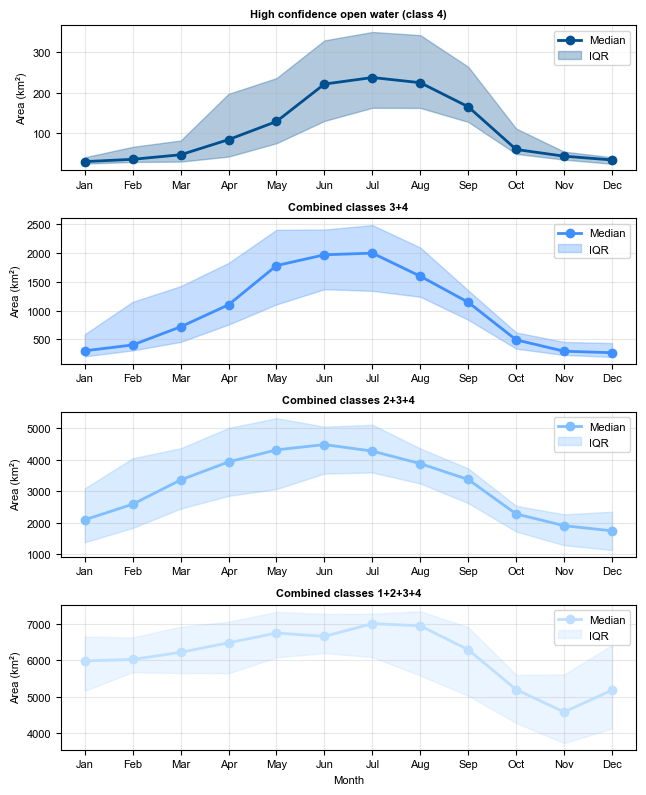

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_seasonal_data(csv_path):
    """
    Load and process monthly DSWE data from CSV.
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file with monthly DSWE summaries
    
    Returns:
    --------
    pd.DataFrame
        Monthly statistics with median and IQR for each confidence threshold
    """
    # Load raw data
    raw_df = pd.read_csv(csv_path)
    raw_df['date'] = pd.to_datetime(raw_df['date'])
    raw_df['month'] = raw_df['date'].dt.month
    
    # Calculate combined areas
    raw_df['area_4'] = raw_df['area_km2_4']
    raw_df['area_34'] = raw_df['area_km2_3'] + raw_df['area_km2_4']
    raw_df['area_234'] = raw_df['area_km2_2'] + raw_df['area_km2_3'] + raw_df['area_km2_4']
    raw_df['area_1234'] = raw_df['area_km2_1to4']
    
    # Group by month and calculate statistics
    df = raw_df.groupby('month').agg({
        'area_4': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_34': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75), 'count'],
        'area_234': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_1234': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
    }).reset_index()
    
    # Flatten column names
    df.columns = ['month', 'median_4', 'q25_4', 'q75_4',
                  'median_34', 'q25_34', 'q75_34', 'n_years',
                  'median_234', 'q25_234', 'q75_234',
                  'median_1234', 'q25_1234', 'q75_1234']
    
    return df

def plot_seasonal_flood_pulse(df):
    """
    Create four-panel plot of seasonal flood pulse.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Processed monthly statistics from load_seasonal_data()
    """
    # Set font to Arial size 8 for all text
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    fig, axes = plt.subplots(4, 1, figsize=(6.5, 8))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Plot 1: Class 4 only (High Confidence Open Water)
    ax0 = axes[0]
    ax0.plot(df['month'], df['median_4'], 'o-', color='#004F8F', linewidth=2, markersize=6, label='Median')
    ax0.fill_between(df['month'], df['q25_4'], df['q75_4'], alpha=0.3, color='#004F8F', label='IQR')
    ax0.set_ylabel('Area (km²)', fontsize=8)
    ax0.set_title('High confidence open water (class 4)', fontsize=8, fontweight='bold')
    ax0.set_xticks(range(1, 13))
    ax0.set_xticklabels(month_names, fontsize=8)
    ax0.tick_params(axis='y', labelsize=8)
    ax0.grid(True, alpha=0.3)
    ax0.legend(loc='upper right', fontsize=8)
    ax0.set_xlim(0.5, 12.5)
    
    # Plot 2: Classes 3+4 (Moderate Confidence Water)
    ax1 = axes[1]
    ax1.plot(df['month'], df['median_34'], 'o-', color='#3F8FFF', linewidth=2, markersize=6, label='Median')
    ax1.fill_between(df['month'], df['q25_34'], df['q75_34'], alpha=0.3, color='#3F8FFF', label='IQR')
    ax1.set_ylabel('Area (km²)', fontsize=8)
    ax1.set_title('Combined classes 3+4', fontsize=8, fontweight='bold')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(month_names, fontsize=8)
    ax1.tick_params(axis='y', labelsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.set_xlim(0.5, 12.5)
    
    # Plot 3: Classes 2+3+4 (Potential Wetland)
    ax2 = axes[2]
    ax2.plot(df['month'], df['median_234'], 'o-', color='#7FBFFF', linewidth=2, markersize=6, label='Median')
    ax2.fill_between(df['month'], df['q25_234'], df['q75_234'], alpha=0.3, color='#7FBFFF', label='IQR')
    ax2.set_ylabel('Area (km²)', fontsize=8)
    ax2.set_title('Combined classes 2+3+4', fontsize=8, fontweight='bold')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(month_names, fontsize=8)
    ax2.tick_params(axis='y', labelsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', fontsize=8)
    ax2.set_xlim(0.5, 12.5)
    
    # Plot 4: Classes 1+2+3+4 (Low Confidence Water)
    ax3 = axes[3]
    ax3.plot(df['month'], df['median_1234'], 'o-', color='#BFDFFF', linewidth=2, markersize=6, label='Median')
    ax3.fill_between(df['month'], df['q25_1234'], df['q75_1234'], alpha=0.3, color='#BFDFFF', label='IQR')
    ax3.set_xlabel('Month', fontsize=8)
    ax3.set_ylabel('Area (km²)', fontsize=8)
    ax3.set_title('Combined classes 1+2+3+4', fontsize=8, fontweight='bold')
    ax3.set_xticks(range(1, 13))
    ax3.set_xticklabels(month_names, fontsize=8)
    ax3.tick_params(axis='y', labelsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=8)
    ax3.set_xlim(0.5, 12.5)
    
    plt.tight_layout()
    plt.show()

# Usage:
csv_path = r"D:\Okavango\Data\Inundation\Extents\LS_AdDSWE_monthly_summary_01082026.csv"
df = load_seasonal_data(csv_path)
plot_seasonal_flood_pulse(df)

Figures saved to D:\Okavango\Data\Inundation\Extents


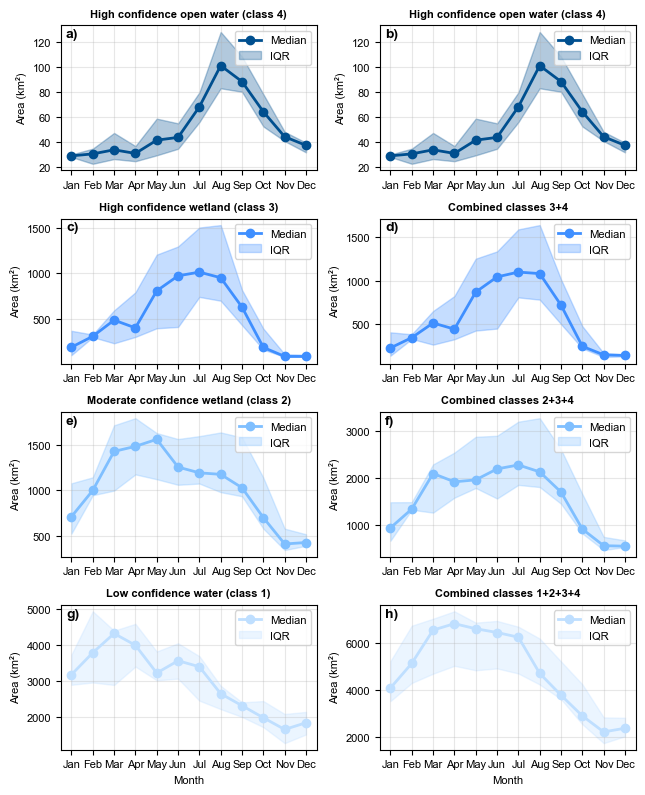

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_seasonal_data(csv_path):
    """
    Load and process monthly DSWE data from CSV for both individual and cumulative classes.
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file with monthly DSWE summaries
    
    Returns:
    --------
    pd.DataFrame
        Monthly statistics with median and IQR for individual and cumulative classes
    """
    # Load raw data
    raw_df = pd.read_csv(csv_path)
    raw_df['date'] = pd.to_datetime(raw_df['date'])
    raw_df['month'] = raw_df['date'].dt.month
    
    # Individual class areas
    raw_df['area_1'] = raw_df['area_km2_1']
    raw_df['area_2'] = raw_df['area_km2_2']
    raw_df['area_3'] = raw_df['area_km2_3']
    raw_df['area_4'] = raw_df['area_km2_4']
    
    # Cumulative class areas
    raw_df['area_4cum'] = raw_df['area_km2_4']
    raw_df['area_34cum'] = raw_df['area_km2_3'] + raw_df['area_km2_4']
    raw_df['area_234cum'] = raw_df['area_km2_2'] + raw_df['area_km2_3'] + raw_df['area_km2_4']
    raw_df['area_1234cum'] = raw_df['area_km2_1to4']
    
    # Group by month and calculate statistics
    df = raw_df.groupby('month').agg({
        # Individual classes
        'area_4': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75), 'count'],
        'area_3': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_2': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_1': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        # Cumulative classes
        'area_4cum': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_34cum': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_234cum': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
        'area_1234cum': ['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
    }).reset_index()
    
    # Flatten column names
    df.columns = ['month', 
                  'median_4', 'q25_4', 'q75_4', 'n_years',
                  'median_3', 'q25_3', 'q75_3',
                  'median_2', 'q25_2', 'q75_2',
                  'median_1', 'q25_1', 'q75_1',
                  'median_4cum', 'q25_4cum', 'q75_4cum',
                  'median_34cum', 'q25_34cum', 'q75_34cum',
                  'median_234cum', 'q25_234cum', 'q75_234cum',
                  'median_1234cum', 'q25_1234cum', 'q75_1234cum']
    
    return df

def plot_seasonal_flood_pulse(df):
    """
    Create 8-panel plot (2 columns x 4 rows) of seasonal flood pulse.
    Left column: Individual classes
    Right column: Cumulative classes
    
    Parameters:
    -----------
    df : pd.DataFrame
        Processed monthly statistics from load_seasonal_data()
    """
    # Set font to Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    fig, axes = plt.subplots(4, 2, figsize=(6.5, 8))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Panel labels
    labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
    
    # Row 1: Class 4 (individual) and Class 4 (cumulative)
    # Left panel (a)
    ax = axes[0, 0]
    ax.plot(df['month'], df['median_4'], 'o-', color='#004F8F', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_4'], df['q75_4'], alpha=0.3, color='#004F8F', label='IQR')
    ax.text(0.02, 0.98, labels[0], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('High confidence open water (class 4)', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Right panel (b)
    ax = axes[0, 1]
    ax.plot(df['month'], df['median_4cum'], 'o-', color='#004F8F', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_4cum'], df['q75_4cum'], alpha=0.3, color='#004F8F', label='IQR')
    ax.text(0.02, 0.98, labels[1], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('High confidence open water (class 4)', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Row 2: Class 3 (individual) and Classes 3+4 (cumulative)
    # Left panel (c)
    ax = axes[1, 0]
    ax.plot(df['month'], df['median_3'], 'o-', color='#3F8FFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_3'], df['q75_3'], alpha=0.3, color='#3F8FFF', label='IQR')
    ax.text(0.02, 0.98, labels[2], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('High confidence wetland (class 3)', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Right panel (d)
    ax = axes[1, 1]
    ax.plot(df['month'], df['median_34cum'], 'o-', color='#3F8FFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_34cum'], df['q75_34cum'], alpha=0.3, color='#3F8FFF', label='IQR')
    ax.text(0.02, 0.98, labels[3], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('Combined classes 3+4', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Row 3: Class 2 (individual) and Classes 2+3+4 (cumulative)
    # Left panel (e)
    ax = axes[2, 0]
    ax.plot(df['month'], df['median_2'], 'o-', color='#7FBFFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_2'], df['q75_2'], alpha=0.3, color='#7FBFFF', label='IQR')
    ax.text(0.02, 0.98, labels[4], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('Moderate confidence wetland (class 2)', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Right panel (f)
    ax = axes[2, 1]
    ax.plot(df['month'], df['median_234cum'], 'o-', color='#7FBFFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_234cum'], df['q75_234cum'], alpha=0.3, color='#7FBFFF', label='IQR')
    ax.text(0.02, 0.98, labels[5], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('Combined classes 2+3+4', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Row 4: Class 1 (individual) and Classes 1+2+3+4 (cumulative)
    # Left panel (g)
    ax = axes[3, 0]
    ax.plot(df['month'], df['median_1'], 'o-', color='#BFDFFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_1'], df['q75_1'], alpha=0.3, color='#BFDFFF', label='IQR')
    ax.text(0.02, 0.98, labels[6], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_xlabel('Month', fontsize=8)
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('Low confidence water (class 1)', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    # Right panel (h)
    ax = axes[3, 1]
    ax.plot(df['month'], df['median_1234cum'], 'o-', color='#BFDFFF', linewidth=2, markersize=6, label='Median')
    ax.fill_between(df['month'], df['q25_1234cum'], df['q75_1234cum'], alpha=0.3, color='#BFDFFF', label='IQR')
    ax.text(0.02, 0.98, labels[7], transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_xlabel('Month', fontsize=8)
    ax.set_ylabel('Area (km²)', fontsize=8)
    ax.set_title('Combined classes 1+2+3+4', fontsize=8, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(0.5, 12.5)
    
    plt.tight_layout()
    output_dir = r"D:\Okavango\Data\Inundation\Extents"
    filename = "Sentinel2_seasonal_flood_pulse_8panel"

    # Save as SVG (vector format, best for publications)
    plt.savefig(f"{output_dir}\\{filename}.svg", format='svg', dpi=1000, bbox_inches='tight')

    # Save as PNG (high quality raster)
    plt.savefig(f"{output_dir}\\{filename}.png", format='png', dpi=1000, bbox_inches='tight')

    # Save as JPEG (compressed raster)
    plt.savefig(f"{output_dir}\\{filename}.jpg", format='jpg', dpi=1000, bbox_inches='tight')

    print(f"Figures saved to {output_dir}")

    # Optionally still show the figure
    plt.show()

# Usage:
csv_path = r"D:\Okavango\Data\Inundation\Extents\S2_AdDSWE_monthly_summary_01092026.csv"
df = load_seasonal_data(csv_path)
plot_seasonal_flood_pulse(df)